# Описание проекта

Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Постройте модель для такого предсказания.
Значение метрики RMSE на тестовой выборке должно быть не больше 48.

# План работы

1) Загрузите данные и выполните их ресемплирование по одному часу.

2) Проанализируйте данные.

3) Обучите разные модели с различными гиперпараметрами. Сделайте тестовую выборку размером 10% от исходных данных.

4) Проверьте данные на тестовой выборке и сделайте выводы.

## 1. Подготовка данных

In [1]:
pip install statsmodels

Note: you may need to restart the kernel to use updated packages.


In [2]:
pip install catboost

Note: you may need to restart the kernel to use updated packages.


In [3]:
pip install lightgbm

Note: you may need to restart the kernel to use updated packages.


In [4]:
import pandas as pd
import pathlib
from pathlib import Path
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import GridSearchCV
import warnings
from sklearn.metrics import mean_squared_error
from catboost import Pool, CatBoostRegressor, cv
from lightgbm import LGBMRegressor
warnings.filterwarnings('ignore')

In [5]:
work_path = pathlib.Path.cwd()

In [6]:
data_path = Path(work_path, 'datasets', 'taxi.csv')

In [7]:
#Загрузим данные и осортируем их в порядке возратсания
data_taxi = pd.read_csv(data_path, index_col=[0], parse_dates=[0])
data_taxi.sort_index(inplace=True)
data_taxi.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB


По данным видим, что у нас есть информмация с 1 марта 2018 года, по 31 августа 2018 года.

## 2. Анализ и подготовка данных

<AxesSubplot:xlabel='datetime'>

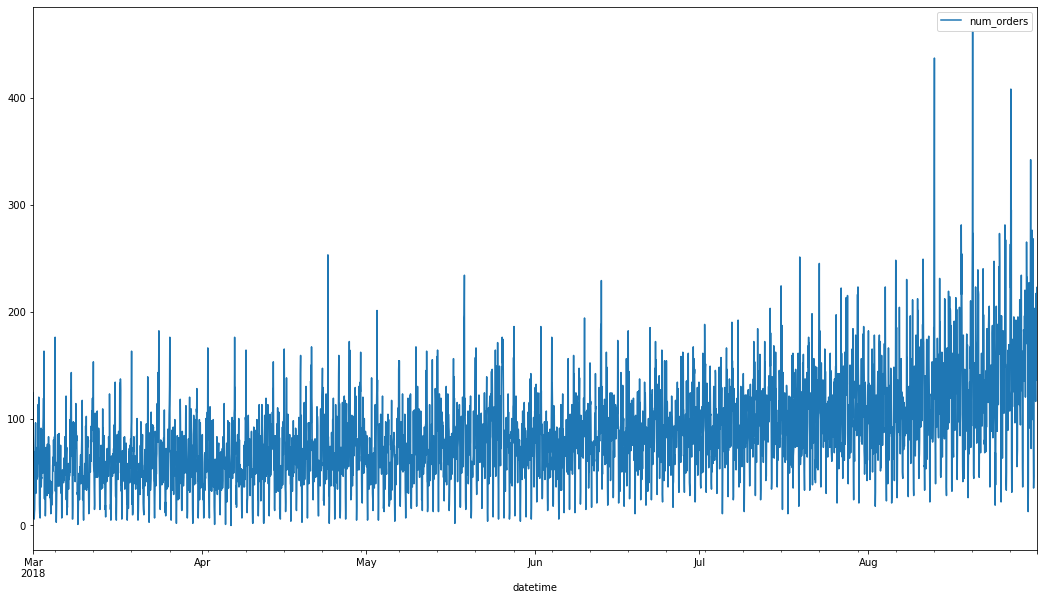

In [8]:
# Построим график с разбивкой по часу
data_taxi = data_taxi .resample('1H').sum()
figsize = (18,10)
data_taxi.plot(figsize=figsize)

Очень интересно, но мало что понятно, рассмотрим меньший период.

<AxesSubplot:xlabel='datetime'>

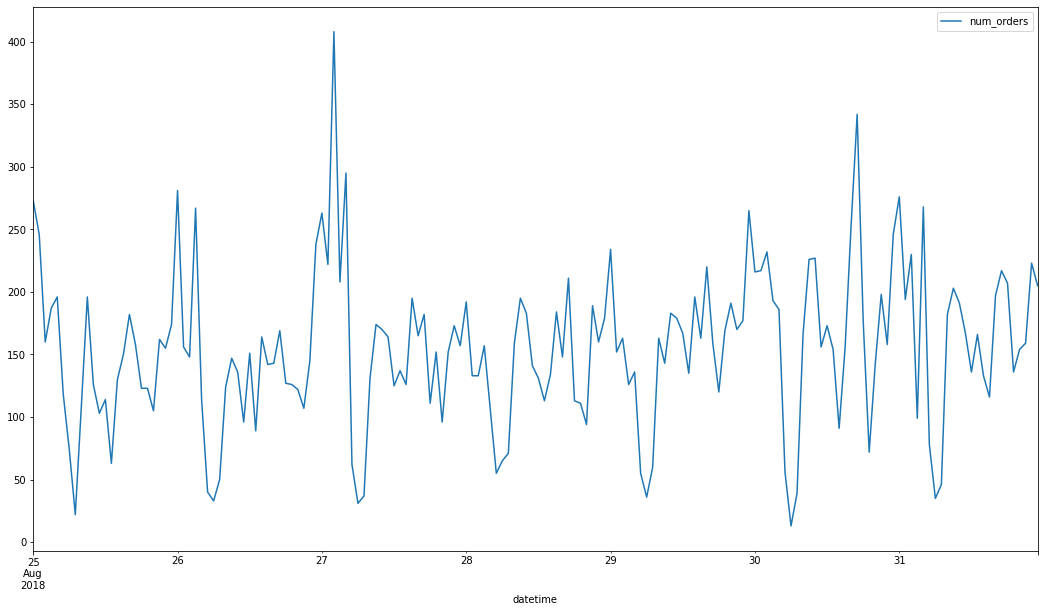

In [9]:
data_taxi['2018-08-25':'2018-08-31'].plot(figsize=figsize)

<AxesSubplot:xlabel='datetime'>

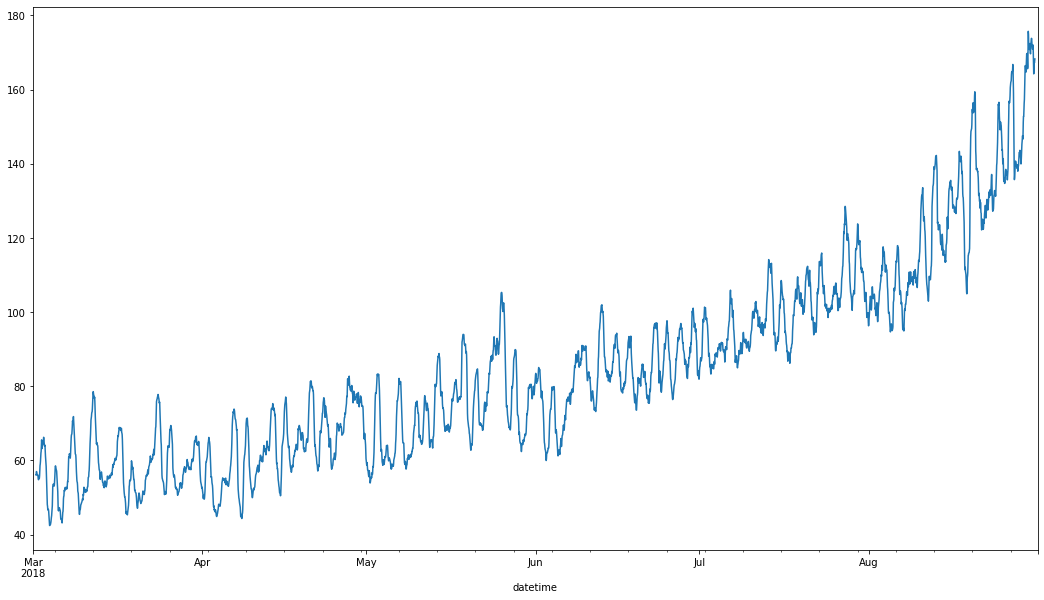

In [10]:
# Рассмотрим тернды, сезонность, остаток декомпозиции заказа такси
decomposed_data_taxi = seasonal_decompose(data_taxi)
decomposed_data_taxi.trend.plot(figsize=figsize)

<AxesSubplot:xlabel='datetime'>

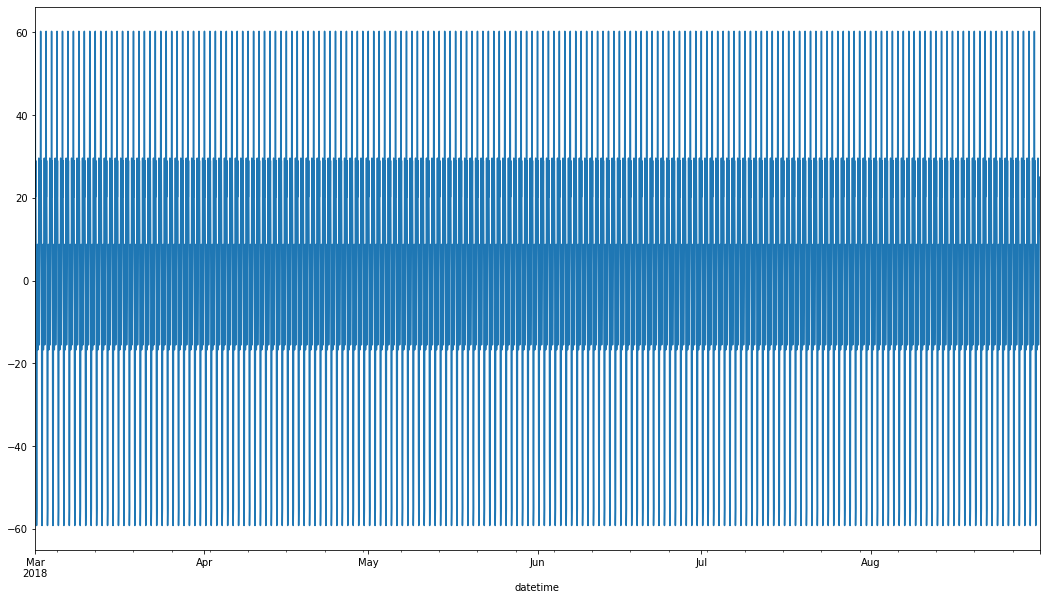

In [11]:
decomposed_data_taxi.seasonal.plot(figsize=figsize)

<AxesSubplot:xlabel='datetime'>

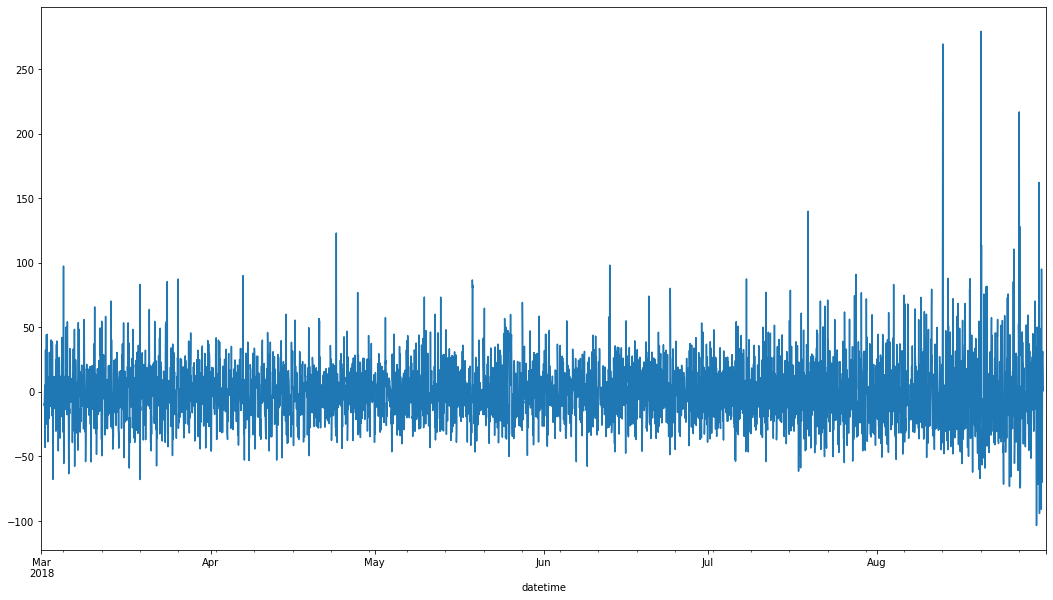

In [12]:
decomposed_data_taxi.resid.plot(figsize=figsize)

Опять же ничего не понятно)

<AxesSubplot:xlabel='datetime'>

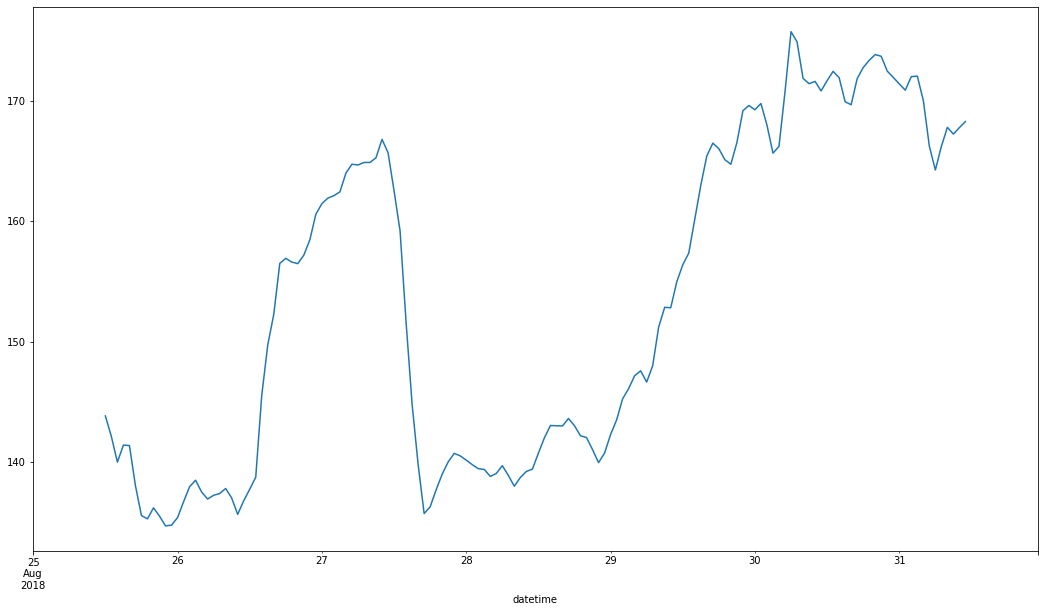

In [13]:
# Рассмотрим тернды, сезонность, остаток декомпозиции заказа такси
decomposed_data_taxi = seasonal_decompose(data_taxi['2018-08-25':'2018-08-31'])
decomposed_data_taxi.trend.plot(figsize=figsize)

<AxesSubplot:xlabel='datetime'>

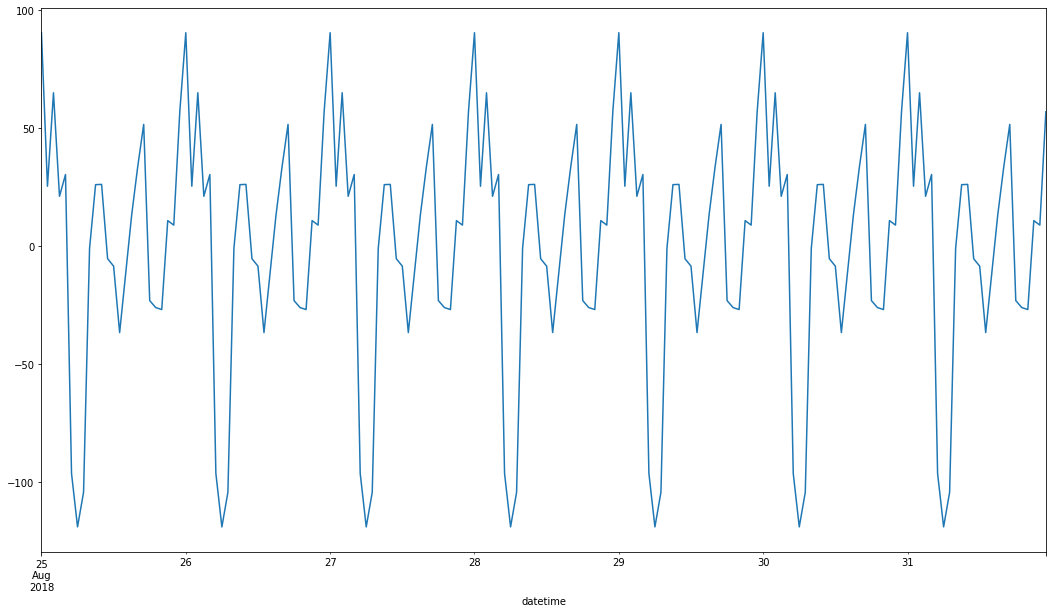

In [14]:
decomposed_data_taxi.seasonal.plot(figsize=figsize)

<AxesSubplot:xlabel='datetime'>

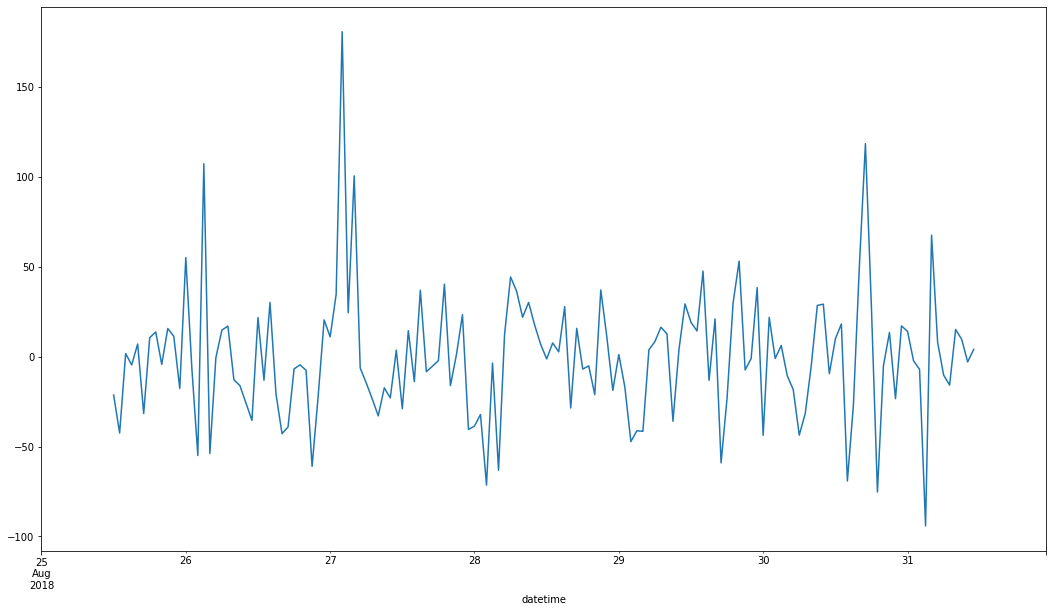

In [15]:
decomposed_data_taxi.resid.plot(figsize=figsize)

**Вывод**

- Дисперсия увеличичвается
- Тренд в общем растет, то есть кол-во заказов и пользователей растет
- Видно что в раннее утро кол-во заказов резко падает
- Временной ряд в не является стационарным, так как подвержен тренду, который меняется во времени.

**Стационарные временные ряды (англ. stationary time series)** — это ряды, у которых среднее и стандартное отклонение не меняются. Когда среднее и стандартное отклонение первого ряда меняется медленнее второго, то первый ряд «более стационарный», чем второй.

<AxesSubplot:xlabel='datetime'>

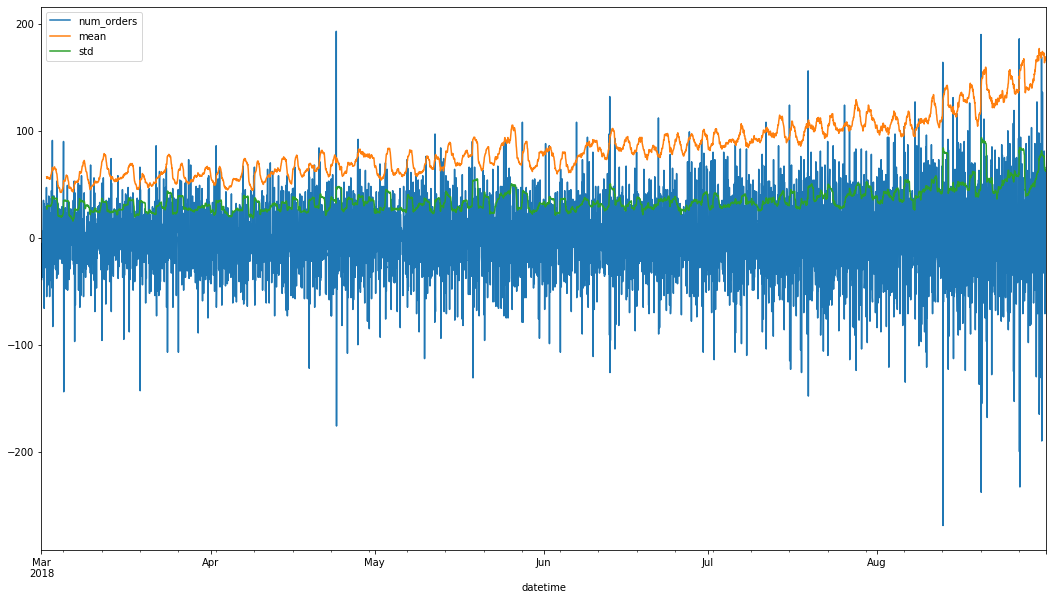

In [16]:
taxi_shift = data_taxi - data_taxi.shift()
taxi_shift['mean'] = data_taxi['num_orders'].rolling(24).mean()
taxi_shift['std'] = data_taxi['num_orders'].rolling(24).std()
taxi_shift.plot(figsize=figsize)

Необходимые нам признаки:
- day так как видно ежедневная сезонность
- month (по графику сезонности)
- dayofweak (по графику остатков)

lag примем как 24 часа

rolling_mean примем как сутки то есть 48 часа

P.S. Подсмотрел параметры в слаке, но следовательно вопрос, а как найти эти параметры, как они влияют на работу? Почему уменьшая их, ухудшается модель, дело в кол-ве данных для обучения? Или тут что-то еще замешано.

In [17]:
# Создадим признаки для обучения модели
max_lag = 24
rolling_mean_size = 48
def make_features(data, column, max_lag, rolling_mean_size):
    data['day'] = data.index.day
    data['dayofweek'] = data.index.dayofweek
    
    for lag in range(1, max_lag + 1):
        data['lag_{}'.format(lag)] = data[column].shift(lag)

    data['rolling_mean'] = data[column].shift().rolling(rolling_mean_size).mean()

In [18]:
data_taxi_copy = data_taxi.copy()

make_features(data_taxi,'num_orders', max_lag, rolling_mean_size)

train, test = train_test_split(data_taxi, shuffle=False, test_size=0.1, random_state=1515)
train = train.dropna()

features_train = train.drop('num_orders', axis=1)
target_train = train['num_orders']
features_test = test.drop('num_orders', axis=1)
target_test = test['num_orders']

## 3. Обучение моделей

### 3.1 Линейная регрессия

In [ ]:
tscv = TimeSeriesSplit(n_splits=8) # А как это аргументировать? =)
gsearch = GridSearchCV(regressor,param_grid = param_set, scoring='neg_mean_squared_error', n_jobs=-1, cv=tscv, verbose=1)
gsearch.fit(features_train, target_train)

In [20]:
%%time
tscv = TimeSeriesSplit(n_splits=8)
regressor = LinearRegression()
print('# Train for root_mean_squared_error')
print()
cv_RMSE_LR = (cross_val_score(regressor, 
                             features_train, 
                             target_train, 
                             cv=tscv, 
                             scoring='neg_mean_squared_error').mean() * -1) ** 0.5
print('Mean RMSE from CV of LinearRegression =', cv_RMSE_LR)

# Train for root_mean_squared_error

Mean RMSE from CV of LinearRegression = 27.146562377544374
Wall time: 64.2 ms


In [21]:
%%time

# С масштабированием
regressor = LinearRegression()
scaller = StandardScaler()
pipeline = Pipeline([("standard_scaller", scaller),("linear_regression", regressor)])
print('# Train for root_mean_squared_error')
print()
cv_RMSE_LR_S = (cross_val_score(pipeline,
                                features_train, 
                                target_train, 
                                cv=5, 
                                scoring='neg_mean_squared_error').mean() * -1) ** 0.5
print('Mean RMSE from CV of LinearRegression =', cv_RMSE_LR_S)

# Train for root_mean_squared_error

Mean RMSE from CV of LinearRegression = 26.280803897631063
Wall time: 62.1 ms


### 3.2 DecisionTree регрессия

In [22]:
%%time

regressor = DecisionTreeRegressor() 
max_depth_list = [x for x in range(2, 15)]
hyperparams = [{'criterion':['mse'], 
                'max_depth':max_depth_list, 
                'random_state':[1515]}]

print('# Tuning hyper-parameters for root_mean_squared_error')
print()
clf = GridSearchCV(regressor, hyperparams, scoring='neg_mean_squared_error')
clf.fit(features_train, target_train)
print("Best parameters set found on development set:")
print()
print(clf.best_params_)
print()
print("Grid scores on development set:")
print()
means = clf.cv_results_['mean_test_score']
stds = clf.cv_results_['std_test_score']
for mean, std, params in zip(means, stds, clf.cv_results_['params']):
    print("%0.6f for %r"% ((mean*-1)** 0.5, params))
print()

cv_RMSE_DTR = (max(means)*-1) ** 0.5

# Tuning hyper-parameters for root_mean_squared_error

Best parameters set found on development set:

{'criterion': 'mse', 'max_depth': 6, 'random_state': 1515}

Grid scores on development set:

31.386359 for {'criterion': 'mse', 'max_depth': 2, 'random_state': 1515}
29.669174 for {'criterion': 'mse', 'max_depth': 3, 'random_state': 1515}
29.654520 for {'criterion': 'mse', 'max_depth': 4, 'random_state': 1515}
29.512509 for {'criterion': 'mse', 'max_depth': 5, 'random_state': 1515}
29.373866 for {'criterion': 'mse', 'max_depth': 6, 'random_state': 1515}
30.071021 for {'criterion': 'mse', 'max_depth': 7, 'random_state': 1515}
30.391807 for {'criterion': 'mse', 'max_depth': 8, 'random_state': 1515}
31.339211 for {'criterion': 'mse', 'max_depth': 9, 'random_state': 1515}
32.324528 for {'criterion': 'mse', 'max_depth': 10, 'random_state': 1515}
33.040934 for {'criterion': 'mse', 'max_depth': 11, 'random_state': 1515}
33.495609 for {'criterion': 'mse', 'max_depth': 12, 'random_state': 1515}

### 3.3 CatBoost регрессия

In [23]:
%%time

regressor = CatBoostRegressor() 
hyperparams = [{'learning_rate':[0.1, 0.2, 0.3],
                'random_state':[1515],
                'verbose':[False]}]

print('# Tuning hyper-parameters for root_mean_squared_error')
print()
clf = GridSearchCV(regressor, hyperparams, scoring='neg_mean_squared_error')
clf.fit(features_train, target_train)
print("Best parameters set found on development set:")
print()
print(clf.best_params_)
print()
print("Grid scores on development set:")
print()
means = clf.cv_results_['mean_test_score']
stds = clf.cv_results_['std_test_score']
for mean, std, params in zip(means, stds, clf.cv_results_['params']):
    print("%0.6f for %r"% ((mean*-1)** 0.5, params))
print()

cv_RMSE_CBR_ordinal = (max(means)*-1) ** 0.5

# Tuning hyper-parameters for root_mean_squared_error

Best parameters set found on development set:

{'learning_rate': 0.1, 'random_state': 1515, 'verbose': False}

Grid scores on development set:

24.446547 for {'learning_rate': 0.1, 'random_state': 1515, 'verbose': False}
24.843760 for {'learning_rate': 0.2, 'random_state': 1515, 'verbose': False}
25.068001 for {'learning_rate': 0.3, 'random_state': 1515, 'verbose': False}

Wall time: 48 s


In [24]:
%%time

regressor = CatBoostRegressor(learning_rate=0.1,
                              iterations = 500,
                              random_state=1515, 
                              verbose=False, 
                              ) 
print('# Train for root_mean_squared_error')
print()
cv_RMSE_CBR_original = (cross_val_score(regressor,
                                features_train, 
                                target_train, 
                                cv=5, 
                                scoring='neg_mean_squared_error').mean() * -1) ** 0.5
print('Mean RMSE from CV of CatBoostRegressor =', cv_RMSE_CBR_original)

# Train for root_mean_squared_error

Mean RMSE from CV of CatBoostRegressor = 24.260820598594574
Wall time: 7.77 s


### 3.4 LGBM регрессия

In [25]:
%%time

regressor = LGBMRegressor() 
hyperparams = [{'learning_rate':[x/10 for x in range(1, 6)],
                'random_state':[1515]}]

print('# Tuning hyper-parameters for root_mean_squared_error')
print()
clf = GridSearchCV(regressor, hyperparams, scoring='neg_mean_squared_error')
clf.fit(features_train, target_train)
print("Best parameters set found on development set:")
print()
print(clf.best_params_)
print()
print("Grid scores on development set:")
print()
means = clf.cv_results_['mean_test_score']
stds = clf.cv_results_['std_test_score']
for mean, std, params in zip(means, stds, clf.cv_results_['params']):
    print("%0.6f for %r"% ((mean*-1)** 0.5, params))
print()

cv_RMSE_LGBMR = (max(means)*-1) ** 0.5

# Tuning hyper-parameters for root_mean_squared_error

Best parameters set found on development set:

{'learning_rate': 0.1, 'random_state': 1515}

Grid scores on development set:

24.871622 for {'learning_rate': 0.1, 'random_state': 1515}
25.500422 for {'learning_rate': 0.2, 'random_state': 1515}
26.044211 for {'learning_rate': 0.3, 'random_state': 1515}
26.789192 for {'learning_rate': 0.4, 'random_state': 1515}
27.596368 for {'learning_rate': 0.5, 'random_state': 1515}

Wall time: 1.51 s


**Вывод** Было использовано 4 регрессионных моделей. Зафиксированы лучшие гиперпараметры и время их выполнения. Catboost показал лучшие результаты

## 4. Тестирвоание моделей

### 4.1 Линейная регрессия

Wall time: 372 ms


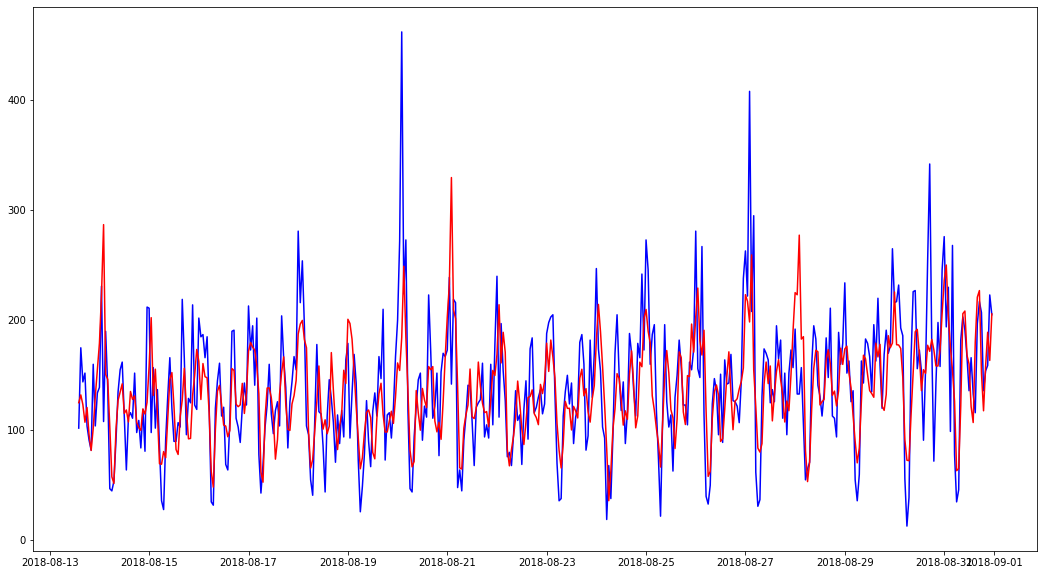

In [26]:
%%time

model = LinearRegression()
model.fit(features_train, target_train)
target_predict = model.predict(features_test)
final_RMSE_LR = mean_squared_error(target_test, target_predict) ** 0.5

plt.figure(figsize=figsize)
plt.plot(target_test.index, 
         target_test, 
         'b-', 
         target_test.index, 
         target_predict,
         'r-')

### 4.2 DecisionTree регрессия

Wall time: 101 ms


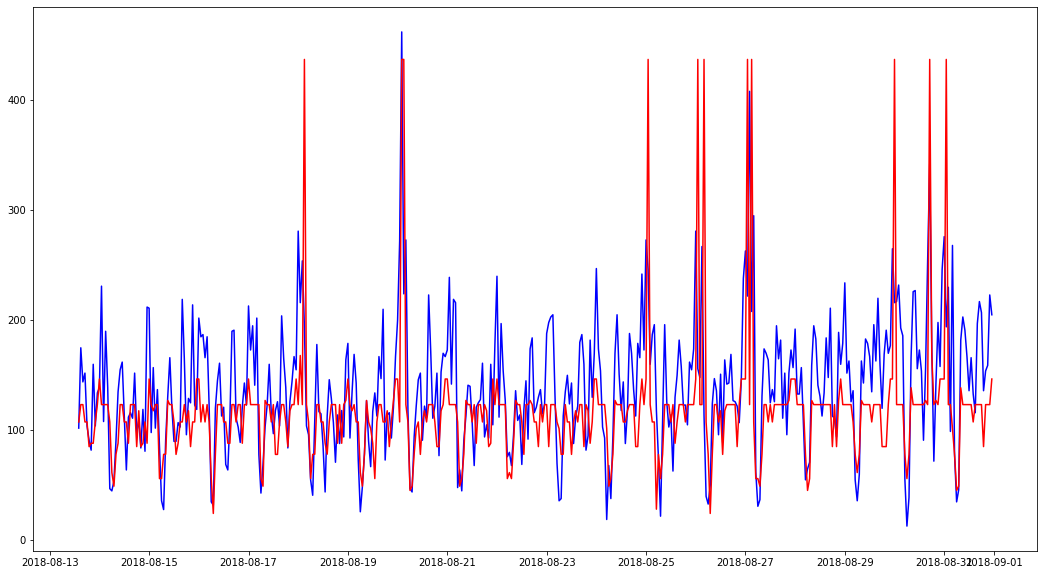

In [27]:
%%time

model = DecisionTreeRegressor(criterion='mse', 
                              max_depth=5, 
                              random_state=1515) 
model.fit(features_train, target_train)
target_predict = model.predict(features_test)
final_RMSE_DTR = mean_squared_error(target_test, target_predict) ** 0.5

plt.figure(figsize=figsize)
plt.plot(target_test.index, 
         target_test, 
         'b-', 
         target_test.index, 
         target_predict,
         'r-')

### 4.3 CatBoost регрессия

Wall time: 3.11 s


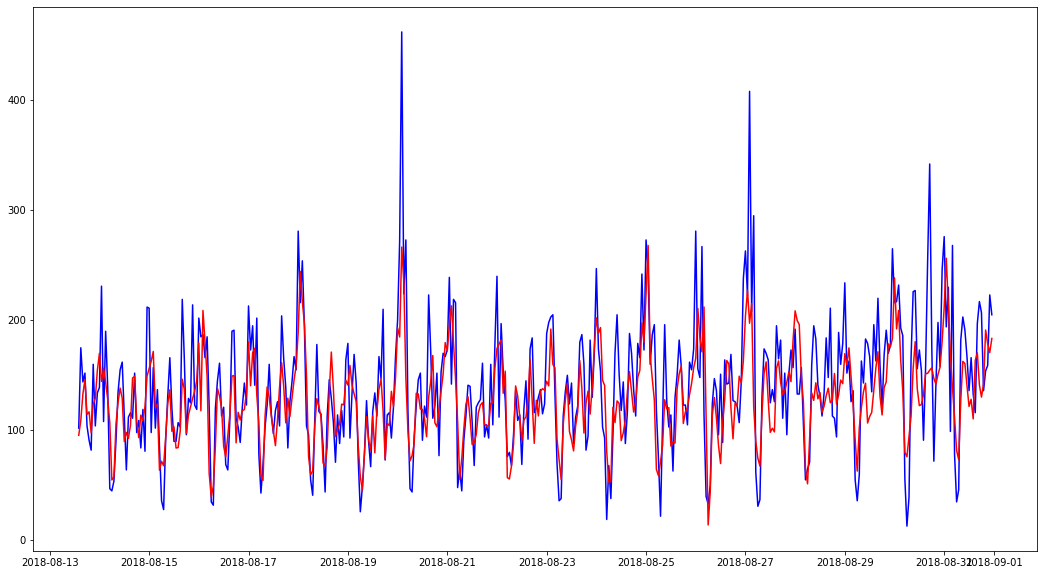

In [28]:
%%time

model = CatBoostRegressor(learning_rate=0.1, 
                          random_state=1515, 
                          verbose=False) 
model.fit(features_train, target_train)
target_predict = model.predict(features_test)
final_RMSE_CBR = mean_squared_error(target_test, target_predict) ** 0.5

plt.figure(figsize=figsize)
plt.plot(target_test.index, 
         target_test, 
         'b-', 
         target_test.index, 
         target_predict,
         'r-')

Wall time: 1.82 s


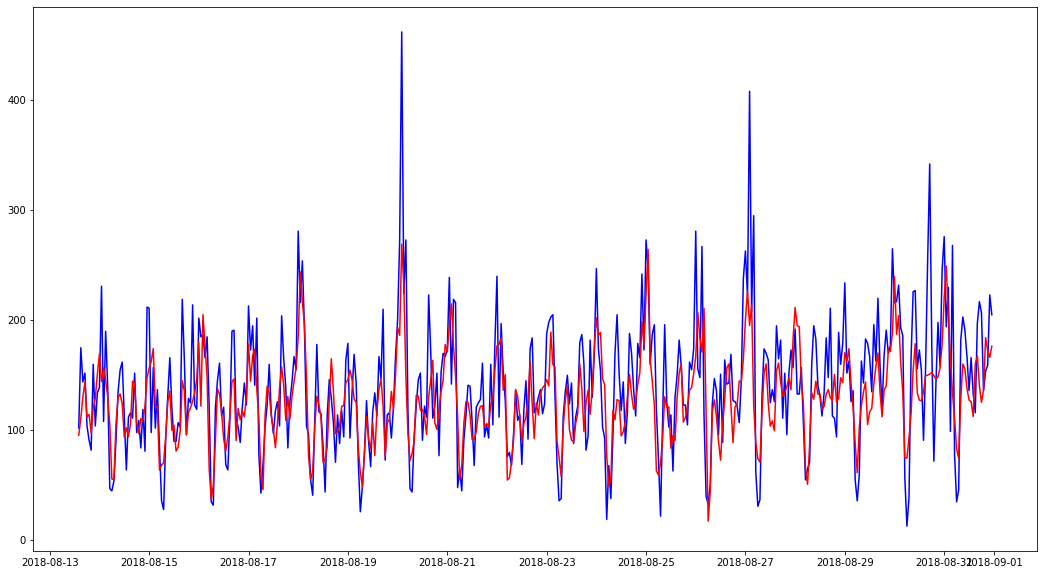

In [29]:
%%time

model = CatBoostRegressor(learning_rate=0.1, 
                          iterations = 500, 
                          random_state=1515, 
                          verbose=False) 
model.fit(features_train, target_train)
target_predict = model.predict(features_test)
final_RMSE_CBR_original = mean_squared_error(target_test, target_predict) ** 0.5
plt.figure(figsize=figsize)
plt.plot(target_test.index, 
         target_test, 
         'b-', 
         target_test.index, 
         target_predict,
         'r-')

### 4.4 LGBM регрессия

Wall time: 393 ms


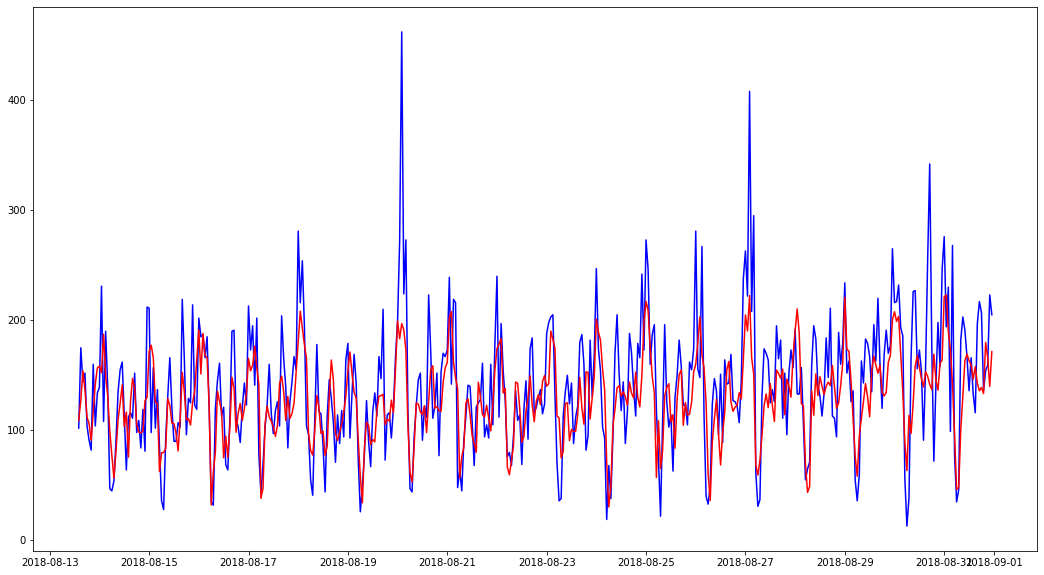

In [30]:
%%time

model = LGBMRegressor(learning_rate=0.1, 
                      num_leaves=500, 
                      random_state=1515)
model.fit(features_train, target_train)
target_predict = model.predict(features_test)
final_RMSE_LGBMR = mean_squared_error(target_test, target_predict) ** 0.5

plt.figure(figsize=figsize)
plt.plot(target_test.index, 
         target_test, 
         'b-', 
         target_test.index, 
         target_predict,
         'r-')

# Итог

In [31]:
index = ['LinearRegression',
         'DecisionTreeRegressor',
         'CatBoostRegressor',
         'CatBoostRegressor no userparameters',
         'LGBMRegressor']
data = {'RMSE на CV':[cv_RMSE_LR,
                      cv_RMSE_DTR,
                      cv_RMSE_CBR_ordinal,
                      cv_RMSE_CBR_original,
                      cv_RMSE_LGBMR],
        'RMSE модели на тестовой выборке':[final_RMSE_LR,
                                           final_RMSE_DTR,
                                           final_RMSE_CBR,
                                           final_RMSE_CBR_original,
                                           final_RMSE_LGBMR]}

scores_data = pd.DataFrame(data=data, index=index)
scores_data['Рейтинг RMSE на CV'] = (scores_data['RMSE на CV'].min() /
                              scores_data['RMSE на CV'])
scores_data['Выполнение задачи'] = scores_data['RMSE модели на тестовой выборке'] < 48.0
scores_data

,RMSE на CV,RMSE модели на тестовой выборке,Рейтинг RMSE на CV,Выполнение задачи
LinearRegression,27.146562,44.893327,0.893698,True
DecisionTreeRegressor,29.373866,62.486632,0.825932,False
CatBoostRegressor,24.446547,41.106134,0.992403,True
CatBoostRegressor no userparameters,24.260821,41.009686,1.000000,True
LGBMRegressor,24.871622,43.400302,0.975442,True


**Вывод**
При lag = 24
и rolling_mean= 48 

Все модели (кроме DTR) выполнели главное условие задачи, а имеенно значение метрики RMSE на тестовой выборке должно быть не больше 48.